# Santander Customer Satisfaction Competition
## Valerie Amoroso


***********************************

**Problem Description:**

From frontline support teams to C-suites, customer satisfaction is a key measure of success. Unhappy customers don't stick around. What's more, unhappy customers rarely voice their dissatisfaction before leaving.

Santander Bank is asking Kagglers to help them identify dissatisfied customers early in their relationship. Doing so would allow Santander to take proactive steps to improve a customer's happiness before it's too late.

In this competition, you'll work with hundreds of anonymized features to predict if a customer is satisfied or dissatisfied with their banking experience.

**Preprocessing Steps:**

The first step in my analysis process was to explore the data and perform preprocessing as necessary.  This dataset contained 76020 observations and 371 anonymized variables.  A summary of what was done is as follows:

- Removed constant features
- Removed duplicate columns
- Imputed mode for errored values (-999999) in var3
- Removed instances of infinity caused by zero division (9999999999)

Once this cleaning was done, I explored variables of interest and created the following features based on the results:
- Num Zeros- captures amount of sparsity per observation
- Adjusted log of var30 - adjusted to account for negatives and reduce outliers
- Log of var38 
- Var38mc - indicator variable for most common value of var38
- Mod3_count - count of the number of features whose values are multiples of 3.
- Variables for balances 3, 2, and 1 time period away for var42 based on linear relationships
- Diff_ind5 - indicator of lack of change between time periods for var5
- Var36_na, var03_na - indicator variables for rows originally containing odd/errored values

The preprocessing, feature exploration, and steps to modeling are described below.

## Data Preprocessing 

In [61]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score, cross_val_predict
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
from sklearn import cross_validation
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel

In [3]:
#Define Functions
#Identifies duplicate columns to be removed
def remove_duplicates(df):
    feature_pairs = list(itertools.combinations(df.columns, 2))
    remove_list = []
    for pair in feature_pairs:
        f1 = pair[0]
        f2 = pair[1]
        if (f1 not in remove_list) & (f2 not in remove_list):
            if (all(df[f1] == df[f2])):
                remove_list.append(f2)
    return remove_list

#Counts the number of observations that are multiples of 3
def mod3_count(x):
    return sum(x % 3 == 0)

#Indicator of number of time periods that are equivalent for var5
def diff_ind5(row):
    if (row['saldo_var5'] == row['saldo_medio_var5_ult1']) | (row['saldo_medio_var5_hace3']+row['saldo_medio_var5_hace2']==0):
        if (row['saldo_medio_var5_ult1']==row['saldo_medio_var5_hace2']) or (row['saldo_medio_var5_hace3']) == 0:
            if row['saldo_medio_var5_hace2'] == row['saldo_medio_var5_hace3']:
                return 3
            else:
                return 2
        else:
            return 1
        
    else:
        return 0

In [4]:
#Read in Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Calculate the percentage of unhappy customers
p = round(float(len(train[train['TARGET'] == 1]))/len(train), 4)
'Percent of dissatisfied customers: {}%'.format(p*100)

'Percent of dissatisfied customers: 3.96%'

Since this is appears to be a sparse matrix, let's first check for contant features -- that is columns which contain all zeros and thus have no added value.

In [5]:
#Remove columns that are all constant (all zero's)
constant = []
keep_cols = []

#Find all features that are constant
for col in train.columns:
    if train[col].nunique() == 1:
        constant.append(col)

print 'Number of Constant Features:', len(constant)
        
#Create a list of all features that are NOT constant for filtering purposes
for col in train.columns:
    if col not in constant:
        keep_cols.append(col)

print 'Original Number of Features:', len(train.columns)
train = train[list(np.setdiff1d(train.columns, constant))]
print 'Number of Features with Constant Features Removed:', len(train.columns)

Number of Constant Features: 34
Original Number of Features: 371
Number of Features with Constant Features Removed: 337


Next, let's check to see if any of the columns are identical-- that is two columns would have the same impact on the target.  We can then remove one of the duplicate columns.

In [6]:
#Remove Duplicate Columns
rl = remove_duplicates(train)
train = train[list(np.setdiff1d(train.columns, rl))]
print 'Number of Duplicate Columns to be removed:', len(rl)
print 'Number of Features with Duplicates Removed:', len(train.columns)

Number of Duplicate Columns to be removed: 29
Number of Features with Duplicates Removed: 308


To see if there are any columns containing odd values, let's check the summary statistics.

In [7]:
#Calculate Summary Statistics
train.describe()

,ID,TARGET,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,...,saldo_var40,saldo_var42,saldo_var44,saldo_var5,saldo_var8,var15,var21,var3,var36,var38
count,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,...,76020.000000,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04
mean,75964.050723,0.039569,2.630887e+05,2.630887e+05,4.867140e+07,5.130229e+06,1.315443e+05,9.208103e+06,4.998685e+06,2.630887e+06,...,4.368602,7.191725e+03,96.352738,1028.468235,141.226784,33.212865,32.549329,-1523.199277,40.449079,1.172358e+05
std,43781.947379,0.194945,5.129183e+07,5.129183e+07,6.959537e+08,2.264435e+08,3.626904e+07,3.033108e+08,2.235230e+08,1.621798e+08,...,113.968756,4.914531e+04,5218.428365,9852.140073,2515.656302,12.956486,393.834939,39033.462364,47.362719,1.826646e+05
min,1.000000,0.000000,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,...,-0.900000,-4.942260e+03,0.000000,-2895.720000,-4942.260000,5.000000,0.000000,-999999.000000,0.000000,5.163750e+03
25%,38104.750000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,23.000000,0.000000,2.000000,2.000000,6.787061e+04
50%,76043.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,3.000000e+00,0.000000,3.000000,0.000000,28.000000,0.000000,2.000000,3.000000,1.064092e+05
75%,113748.750000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,1.200000e+02,0.000000,90.000000,0.000000,40.000000,0.000000,2.000000,99.000000,1.187563e+05
max,151838.000000,1.000000,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10,...,8192.610000,3.008077e+06,740006.610000,619329.150000,240045.000000,105.000000,30000.000000,238.000000,99.000000,2.203474e+07


It appears var3 represents a categorical value, blog posts indicate possibly customer nationality and thus it is most likely that this value represents unknown nationality.  Let's replace these unknown with the most common nationality value.

In [8]:
#Find most common nationality
train.var3.value_counts()[:10]

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64

In [9]:
#Replace errored values with most common value of 2
train.var3 = train.var3.replace(-999999, 2)

Further investigation also shows that some columns have an unusually high maximum value of 9999999999.  This appears to also be an error, as all of these columns belong to delta variables, meaning they represent some kind of change an possible division by zero has created an infinite number.  
We can do a quick calculation to see how many of these errored rows correspond to a target of 1, and only keep columns where this is true, as removing these rows would lead to constant columns. 

In [10]:
error_cols= []
for col in train.columns:
    if train[col].max() == 9999999999:
        error_cols.append(col)
        
keep_col = []
del_col = []
for col in error_cols:
    v = len(train[col].value_counts())
    s= sum(train['TARGET'][train[col] == 9999999999])
    if s >0:
        keep_col.append(col)
        #print 'Keep me'
    if (v == 2) & (s == 0):
        del_col.append(col)
        #print 'Delete Column'  
        
print 'The number of columns containing delta values corresponding to a target of 1:', len(keep_col)
print 'The number of columns containing delta values corresponding to a target of 0:', len(del_col)
print '\nRemoving', len(del_col), 'Columns:'
for col in del_col:
    print col

#Remove columns where errored values exist that correspond to only target values of 0.  Removing the errored rows would lead to constant feature.
train = train[list(np.setdiff1d(train.columns, del_col))]

The number of columns containing delta values corresponding to a target of 1: 8
The number of columns containing delta values corresponding to a target of 0: 5

Removing 5 Columns:
delta_imp_amort_var18_1y3
delta_imp_amort_var34_1y3
delta_imp_reemb_var33_1y3
delta_imp_trasp_var17_out_1y3
delta_imp_trasp_var33_out_1y3


## Feature Exploration - Satisfied vs. Unsatisfied
To further explore features and their effect on the target variable, we can split the dataset into two groups -- satisfied customers, and unsatisfied customers, and explore whether there are any distinguishable features of unsatisfied customers.  Since the features are anonymized and there are over 300, a simple random forest model was created and the built in feature importances were used to identify features that were worth exploring.  Some of these features, along with sparsity are explored below.

In [11]:
#Split into target 0 and target 1 to explore differences between satisfied customers and unsatisfied customers
unsat = train[train['TARGET'] == 1]
sat = train[train['TARGET'] == 0]

### Sparsity
Since this dataset is so sparse, let's see if there is a difference between amount of sparsity that exists between satisfied and unsatisfied customers.

In [12]:
#Split into target 0 and target 1 to explore differences between satisfied and unsatisfied customers
print 'Difference between average number of zeros per row for unsatisfied customers vs. all customers:',(unsat == 0).astype(int).sum(axis=1).mean() - (train == 0).astype(int).sum(axis=1).mean()
print 'Difference between average number of zeros per row for satisfied customers vs. all customers:',(sat == 0).astype(int).sum(axis=1).mean() - (train == 0).astype(int).sum(axis=1).mean()

Difference between average number of zeros per row for unsatisfied customers vs. all customers: 5.34141031266
Difference between average number of zeros per row for satisfied customers vs. all customers: -0.220059198768


Text(0.5,0,u'Number of Zeros')

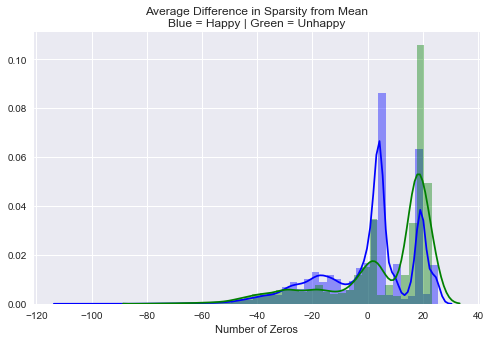

In [13]:
%matplotlib inline
plt.subplots(figsize=(8,5))
sns.distplot((sat == 0).astype(int).sum(axis=1)-(train == 0).astype(int).sum(axis=1).mean(), color = 'b')
sns.distplot((unsat == 0).astype(int).sum(axis =1)-(train == 0).astype(int).sum(axis=1).mean(), color = 'g')
sns.plt.title('Average Difference in Sparsity from Mean\nBlue = Happy | Green = Unhappy')
sns.plt.xlabel('Number of Zeros')

There appears to be a distinguishable difference between the distributions for satisfied and unsatisfied customers, with unsatisfied customers having 'sparser' rows on average than those of satisfied customers. Since the variables are anonomyzed, it is hard to determine exactly why this might be, but a feature can be engineered to capture this difference. 

### Saldo Var 30
Saldo Var30 has a wide spread and is not normally distributed. For better visualization and to reduce outliers we can take the log of this to compare the distributions.

Text(0.5,1,u'Distribution of Saldo Var 30')

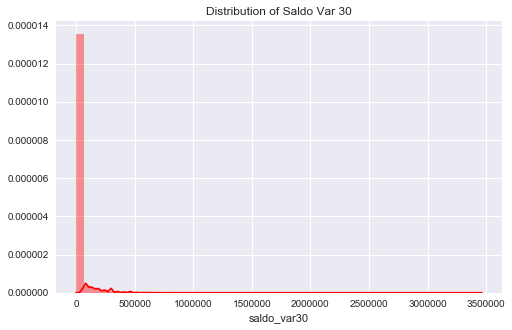

In [14]:
#Plot Saldo Var 30 Distribution
plt.subplots(figsize=(8,5))
sns.distplot(sat.saldo_var30 + abs(sat.saldo_var30.min()), color = 'r')
sns.plt.title('Distribution of Saldo Var 30')

Text(0.5,0,u'Log Var 30')

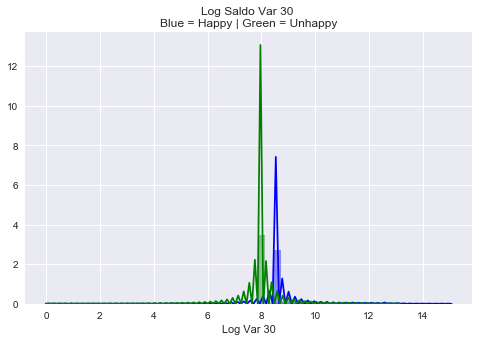

In [15]:
#Plot Log Saldo Var 30 by Happy vs. Unhappy
plt.subplots(figsize=(8,5))
sat_log_var30 = [np.log(y) if y != 0 else 0 for y in sat.saldo_var30 + abs(sat.saldo_var30.min())]
unsat_log_var30 = [np.log(y) if y != 0 else 0 for y in unsat.saldo_var30 + abs(unsat.saldo_var30.min())]
sns.distplot(sat_log_var30, color = 'b')
sns.distplot(unsat_log_var30, color = 'g')
sns.plt.title('Log Saldo Var 30 \nBlue = Happy | Green = Unhappy')
sns.plt.xlabel('Log Var 30')

In [16]:
train['Adjusted_Log_Var30'] = train.saldo_var30 + abs(train.saldo_var30.min())
train['Adjusted_Log_Var30'] = train.Adjusted_Log_Var30.map(np.log)

There is a distinguishable difference between happy and unhappy customers and the log of their balance (saldo) for variable 30, so we should include this as a variable.

### Var 15
Var 15 is identified as one of the most important features, and hypothesized to be the age of a customer.  The plot below illustrates that customers that are unhappy tend to be older, and specifically, no one under the age of 23 in this dataset is unhappy. 

Text(0.5,0,u'Customer Age')

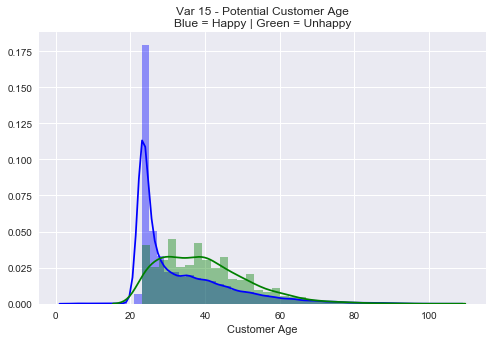

In [17]:
plt.subplots(figsize=(8,5))
sns.distplot(sat.var15, color = 'b')
sns.distplot(unsat.var15, color= 'g')
sns.plt.title('Var 15 - Potential Customer Age\nBlue = Happy | Green = Unhappy')
sns.plt.xlabel('Customer Age')

In [18]:
print 'Minimum age of unhappy customers:', unsat.var15.min()
print 'Minimum age of happy customers:', sat.var15.min()

Minimum age of unhappy customers: 23
Minimum age of happy customers: 5


### Var 38
Var 38 looks to have a wide spread as well - it is thought this might be a customers mortgage value.  
Looking at the plot below it can be seen that there is a large spike in the distribution indicating that there are a cluster of numbers with the same value -- 14868 out of 76020 numbers are all 117310.979016.  Doing some research it appears other competitors have hypothesized this value to be a filled value for missing numbers, possibly the mean or median.  Calculating the mean of all training values, we get 117235.80943037664, which is very close to this number. One method for model improvement could be to try replacing these values with a more accurate imputation (such as KNN) or value from a fitted model (Random Forest, GBM).

Text(0.5,1,u'Distribution of Var 38')

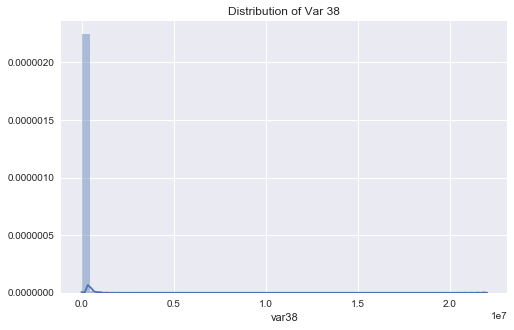

In [19]:
#Plot Distribution of Var38
plt.subplots(figsize=(8,5))
sns.distplot(train.var38)
sns.plt.title('Distribution of Var 38')

In [20]:
#Find value of spike
print 'The mode of var38 is:', round(train.var38.mode(), 6)
print 'The number of values in the dataset which have this value:', sum((train.var38 >= 117310.979015) & (train.var38 <= 117310.979017))
print 'The mean of all var38 values:', train.var38[train['var38'] != 117310.979016494].mean()

The mode of var38 is: 117310.979016
The number of values in the dataset which have this value: 14868
The mean of all var38 values: 117217.533308


Text(0.5,1,u'Log Var 38 \nBlue = Happy | Green = Unhappy')

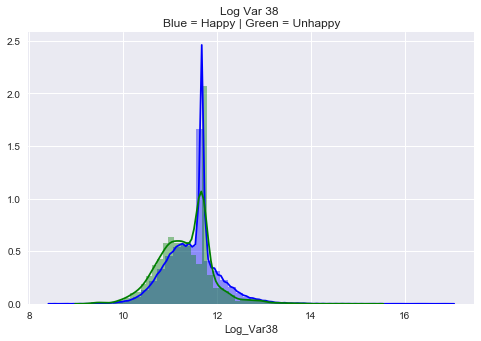

In [21]:
#Create mapping of var38 to Log_var38
sat['Log_Var38'] = [np.log(y) if y != 0 else 0 for y in sat.var38]

unsat['Log_Var38'] = [np.log(y) if y != 0 else 0 for y in unsat.var38]

train['Log_Var38'] = [np.log(y) if y != 0 else 0 for y in train.var38]

#Plot Log_var38
plt.subplots(figsize=(8,5))
sns.distplot(sat.Log_Var38, color = 'b')
sns.distplot(unsat.Log_Var38, color = 'g')
sns.plt.title('Log Var 38 \nBlue = Happy | Green = Unhappy')

Text(0.5,1,u'Log Var 38 \nBlue = Happy | Green = Unhappy')

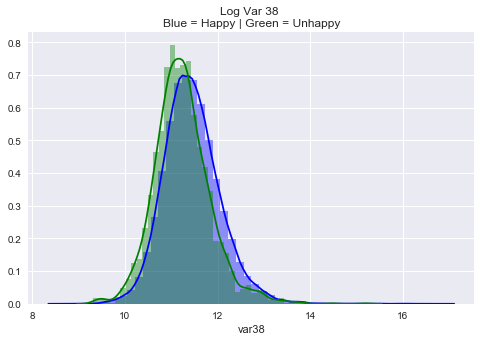

In [39]:
#Removing the spike
plt.subplots(figsize=(8,5))
sns.distplot(sat.loc[~np.isclose(sat.var38, 117310.979016), 'var38'].map(np.log), color = 'b')
sns.distplot(unsat.loc[~np.isclose(unsat.var38, 117310.979016), 'var38'].map(np.log), color = 'g')
sns.plt.title('Log Var 38 \nBlue = Happy | Green = Unhappy')

The above plots now look like two close to normal distributions.  This suggests we can create two new variables. One will indicate whether or not the value in var38 is the most common value.  The second will be the log transformation of var38 when it is not the most common value.

In [23]:
train['var38mc'] = np.isclose(train.var38, 117310.979016)
train['logvar38'] = train.loc[~train['var38mc'], 'var38'].map(np.log)
train.loc[train['var38mc'], 'logvar38'] = 0

### Interaction between var15 (Potential Age) and var38 (Potential Mortgage/Customer Value)

Text(0.5,1,u'Interaction between Var15 and Var38')

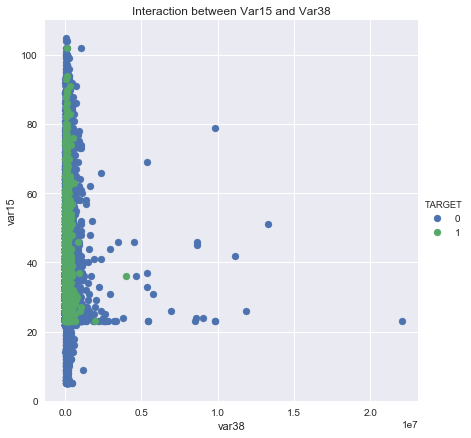

In [24]:
sns.FacetGrid(train, hue="TARGET", size=6).map(plt.scatter, "var38", "var15").add_legend()
sns.plt.title('Interaction between Var15 and Var38')

Text(0.5,1,u'Interaction between Log Var 38 and Var15')

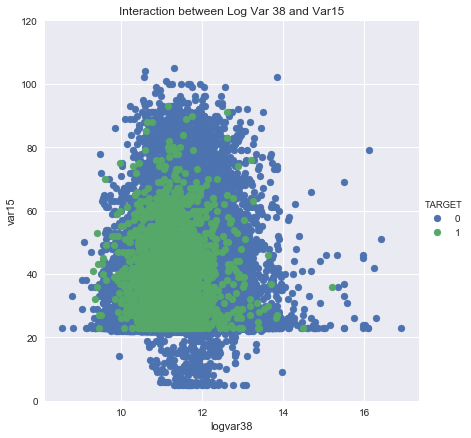

In [25]:
#Plot iteraction of log var38 and var15 with most common log var38 removed
sns.FacetGrid(train[~train.var38mc], hue="TARGET", size=6).map(plt.scatter, "logvar38", "var15").add_legend()
sns.plt.ylim([0,120])
sns.plt.title('Interaction between Log Var 38 and Var15')

Text(0.5,1,u'Potential Age Distribution when Var38 is Most Common')

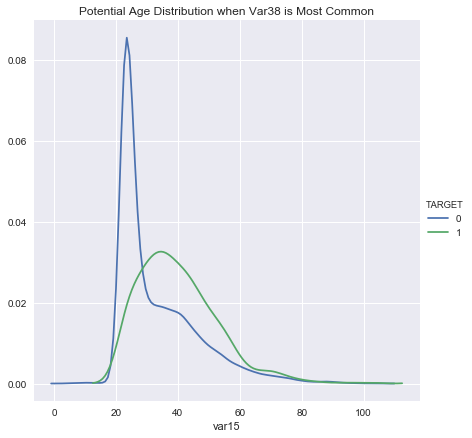

In [26]:
#Plot distribution of var15 - age, when var38 is at it's most common value
sns.FacetGrid(train[train.var38mc], hue="TARGET", size=6).map(sns.kdeplot, "var15").add_legend()
sns.plt.title('Potential Age Distribution when Var38 is Most Common')

### Num_Var4
Num_Var4 is thought to be the number of banking products a customer has.  The plots below illustrate that unsatisfied customers usually have less products than satisfied customers. 

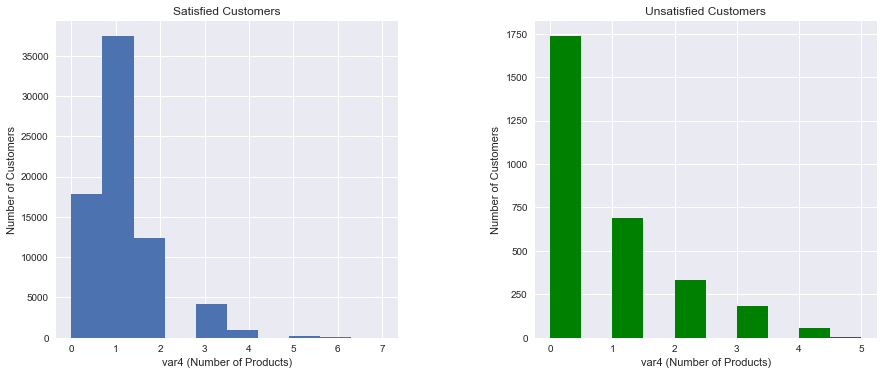

In [27]:
plt.subplot(1,2,1)
sat.num_var4.hist()
plt.title('Satisfied Customers')
plt.xlabel('var4 (Number of Products)')
plt.ylabel('Number of Customers')

plt.subplot(1,2,2)
unsat.num_var4.hist(color = 'g')
plt.title('Unsatisfied Customers')
plt.xlabel('var4 (Number of Products)')
plt.ylabel('Number of Customers')
sns.plt.subplots_adjust(left=.1, bottom=-.1, right=2, top=1, wspace=.4, hspace=.1)

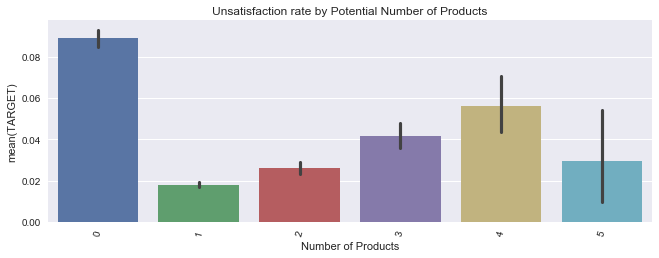

In [28]:
sns.barplot(y = 'TARGET' , x = 'num_var4', data = train, order = unsat['num_var4'].value_counts().index )
sns.plt.title('Unsatisfaction rate by Potential Number of Products')
sns.plt.xlabel('Number of Products')
sns.plt.xticks(rotation = '75')
sns.plt.subplots_adjust(left=.1, bottom=.3, right=1.5, top=1, wspace=.4, hspace=.1)

[[Text(0,0,u'Satisfied'), Text(0,0,u'Unsatisfied')]]

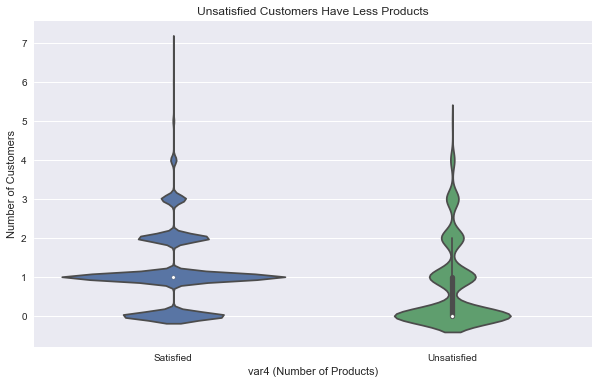

In [29]:
plt.subplots(figsize=(10,6))
v = sns.violinplot(y='num_var4', x = 'TARGET', data=train)
plt.title('Unsatisfied Customers Have Less Products')
plt.xlabel('var4 (Number of Products)')
plt.ylabel('Number of Customers')
v.set(xticklabels = ['Satisfied', 'Unsatisfied'])

### Var36
Var36 appears to be a categorical variable that has values 0,1,2,3, or 99.  The plot below shows that more unhappy customers exist when var36 = 99.  Specifically when var36 = 0, there are only satisfied customers.

In [30]:
train.var36.value_counts()

99    30064
3     22177
1     14664
2      8704
0       411
Name: var36, dtype: int64

Text(0.5,1,u'var36 - Happy vs. Unhappy Customers')

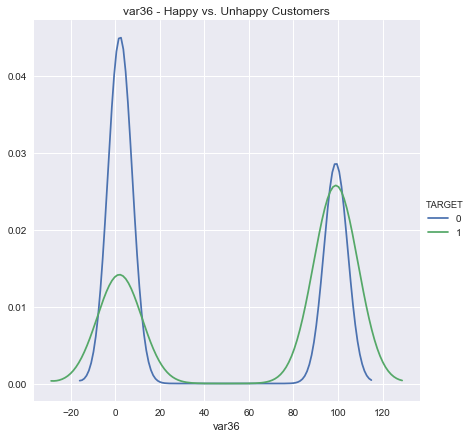

In [31]:
sns.FacetGrid(train, hue="TARGET", size=6).map(sns.kdeplot, "var36").add_legend()
plt.title('var36 - Happy vs. Unhappy Customers')

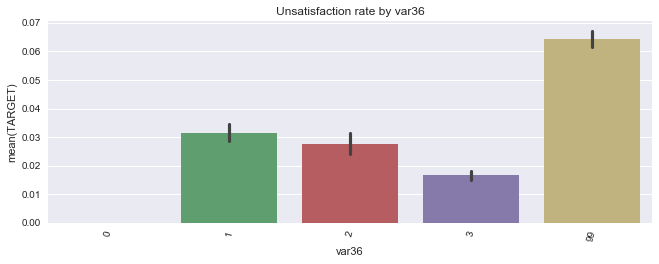

In [32]:
sns.barplot(y = 'TARGET' , x = 'var36', data = train)
sns.plt.title('Unsatisfaction rate by var36')
sns.plt.xlabel('var36')
sns.plt.xticks(rotation = '75')
sns.plt.subplots_adjust(left=.1, bottom=.3, right=1.5, top=1, wspace=.4, hspace=.1)

In [33]:
x = sat.saldo_var37.describe()
y = unsat.saldo_var37.describe()
ind = list(y.index)
pd.DataFrame({'Satisfied':x, 'Unsatisfied': y})

,Satisfied,Unsatisfied
count,73012.000000,3008.000000
mean,36.477825,47.329099
std,471.663045,482.519459
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,60000.000000,21261.090000


### Multiples of 3 

Through data exploration it was noticed that many columns have values that are only multiples of 3.  Creating a mod3 variable it can be seen that there is somewhat of a difference between the the count of mod3 columns for satisfied and unsatisfied customers.  This count can be added as a feature for modeling.

Text(0.5,1,u'Mod 3 Count')

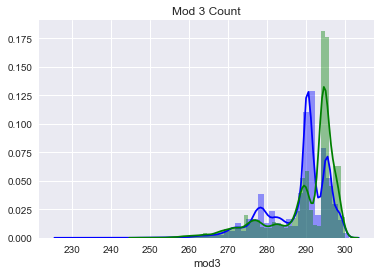

In [34]:
train['mod3'] = train.apply(mod3_count, axis = 1)
test['mod3'] = test.apply(mod3_count, axis = 1)

unsat = train[train['TARGET'] == 1]
sat = train[train['TARGET'] == 0]

sns.distplot(sat.mod3, color = 'b')
sns.distplot(unsat.mod3, color = 'g')
sns.plt.title('Mod 3 Count')

### Pairplot of Top Features

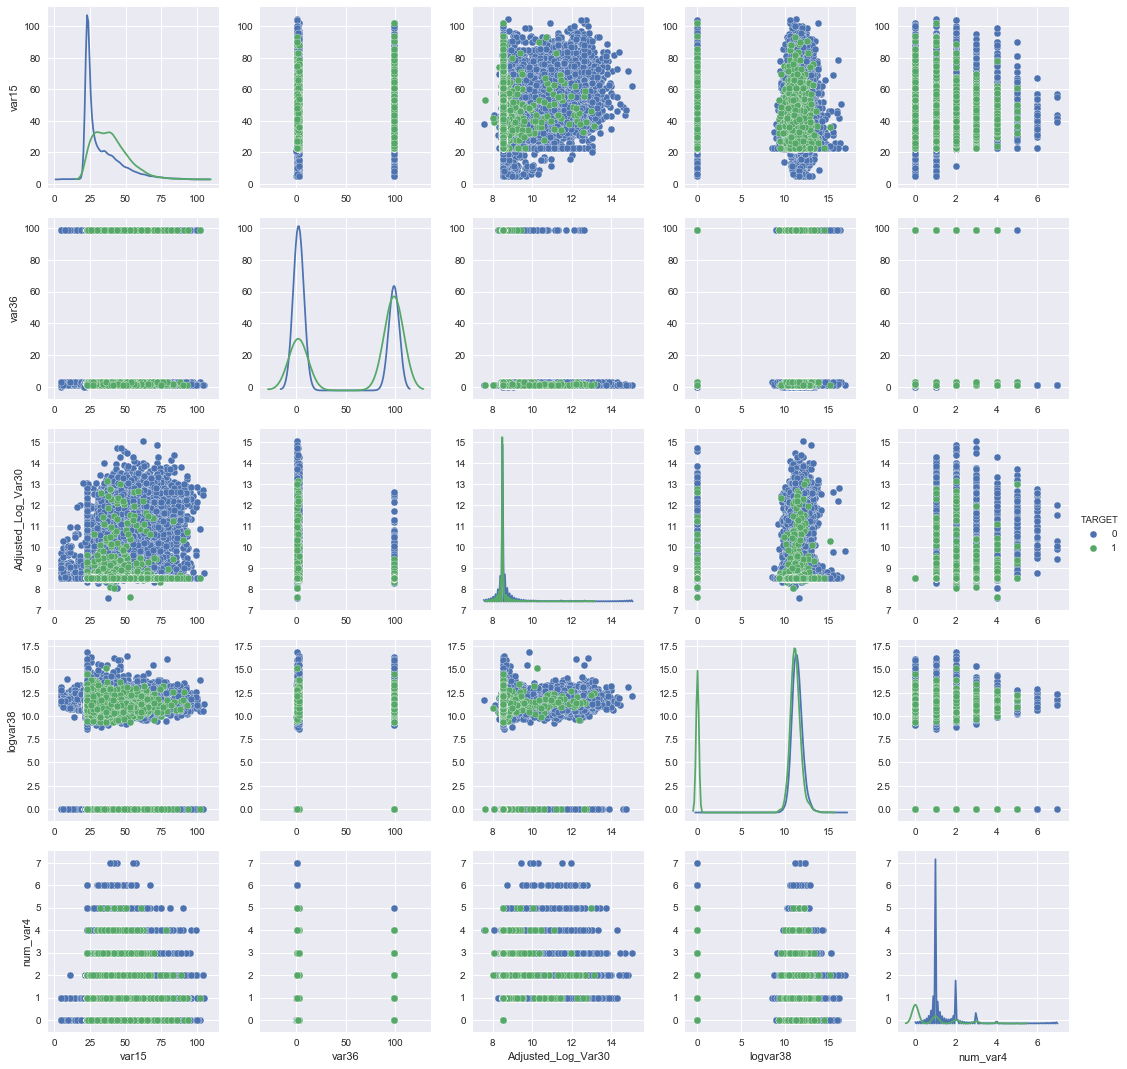

In [35]:
sns.pairplot(train[['var15','var36','logvar38', 'Adjusted_Log_Var30', 'num_var4', 'TARGET']], vars=['var15', 'var36', 'Adjusted_Log_Var30', 'logvar38', 'num_var4'], hue='TARGET', size=3, diag_kind="kde")

### Multi-Variate Radial Plot

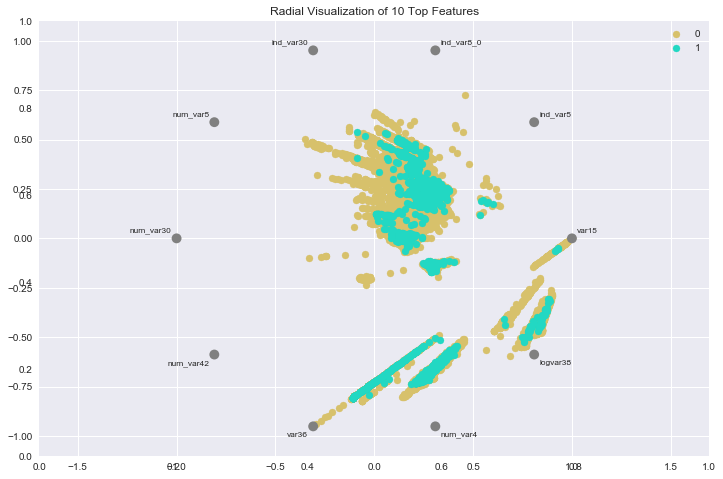

In [36]:
import matplotlib.pyplot as plt
from pandas.tools.plotting import radviz

plt.subplots(figsize=(12,8))
radviz(train[['var15','ind_var5','ind_var8_0','ind_var30','num_var5','num_var30','num_var42','var36','num_var4','logvar38',
 'TARGET']], 'TARGET')

plt.title('Radial Visualization of 10 Top Features')
plt.figure()

### Correlations

Exploration of this data has shown that many of the variables are highly correlated, and in many cases one variable is function of a set of other variables.  In many models we need to be aware of multi-collinearity, so understanding if variables are correlated and how strongly is important.  The heatmap below shows the correlation between 10 of the top variables.

Text(0.5,1,u'Correlations Between 10 Top Variables')

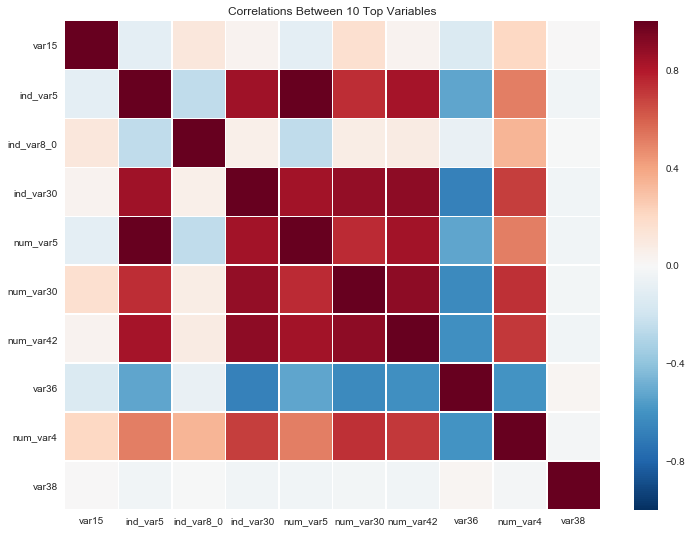

In [37]:
correlation_matrix = train[['var15','ind_var5','ind_var8_0','ind_var30','num_var5','num_var30','num_var42', 'var36','num_var4','var38']].corr()
f, ax = plt.subplots(figsize=(12, 9))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix,linewidths=.5, ax=ax)
sns.plt.title('Correlations Between 10 Top Variables')

## Modeling

During the modeling process, a variety of models and strategies were tried in order to create a model that had the best possible AUC score.  Issues that I tried to address included how to deal with outliers, the imbalanced nature of the dataset, and the large number of anonymized features, and overfitting. Below is a list of methods and models tried:

**Methods:**
- Scaling Features
    - Techniques tried:
        - Min-Max Scalar
        - Mapping the Log Function to the values
        
- Oversampling/Undersampling 
    - Oversampling and Undersampling can help balance out the number of positive and negative classes in the dataset which often improves a models performance.
    - Techniques tried:
        - SMOTE (Synthetic Minority Oversampling Technique)
        - Random Majority Under Sampling with Replacement
        
- PCA
    - Principal Component Analysis can be used to  reduce the number of features by creating principal components that explain the most variance in the data.  
    - The runtime on PCA proved long due to the size of some of the values in the dataset and thus it was difficult to incorporate with limited time.  It was ultimately not used for this reason along with it's lack of interpretibility. 
    
- Feature Selection 
    - Techniques tried:
        - SelectFromModel - ExtraTrees, RandomForest, and Gradient Boost
    
    
- Parameter Tuning via Cross Validated Grid Search

- Early Stopping to reduce overfitting
    
    
**Models:**
- Logistic Regression
- Random Forest Classifier
- Gradient Boosting Classifier
- Extreme Gradient Boosting Classifier (XGB)
- Elastic Net
- Sparse Matrix --> XGB
- Voting Classifier -- Ensembling Multiple Models


**Results:**

Out of all methods and models tried, the model that ended up scoring the highest was an ensembled model made up of four XGB models using Voting Classifier, with an AUC score of .825847 on the Private Leaderboard (top 27th percentile). This model performed best when it was built using all 317 features (after pre-processing and feature engineering). Another model consisting of two ensembled XGB models on the same dataset was a close second (performing slightly higher on Public Leaderbord, but slightly lower on Private). Other models consisting of single XGB models built on the top 37 features selected from a Gradient Boosting Tree came very close to the performance of the ensembled models, but none outperformed. Logistic Regression, Random Forest, Elastic Net, and Gradient Boost alone did not nearly perform as well as all of the XGB models. 

In terms of the imbalanced nature of the dataset, oversampling and undersampling both proved ineffective at improving AUC, and multi-collinearity was not an issue due to the nature of the model used.

The final model's parameters were tuned using a multi-step cross-validated grid search, with the top four model's parameters being used to make the ensemble.  

One of the biggest limitations influencing the results of this challenge for me was time. 
With more time to devote to this project I feel I could make improvements to the model resulting in a better score. Other methods/models that I would have liked to try, but did not have the time to explore include: 
- A neural network model trained in Keras and used as one of the classifiers in the Voting ensemble.
- A stacked model design where one a model is created and then used as an indicator variable in another model.
- KNN (or other fitted model) imputation of the most common value in var38, as it is one of the most significant variables.
- Further explore the differences between the XGB models built between Python and R.  R has a spare.model.matrix that proved effective for many other competitors as a feeder into XGB, but scipy's csc sparse matrix implementation proved ineffective.

I have included the code for only the final model below, though I am happy to share code for less successful models upon request.

### Prepare Data for Modeling

In [38]:
%%time

#Load Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

constant = []
keep_col = []
del_col = []
error_cols= []

#Drop ID and TARGET for modeling
target = train['TARGET']
train = train.drop(['ID', 'TARGET'], axis = 1)
test_id = test.ID
test = test.drop(["ID"],axis=1)

#Create features for the number of zeros
train['Num Zeros'] = (train == 0).astype(int).sum(axis=1)
test['Num Zeros'] = (test == 0).astype(int).sum(axis =1)

#Mod 3 Count
train['mod3'] = train.apply(mod3_count, axis = 1)
test['mod3'] = test.apply(mod3_count, axis = 1)

#Indicator variable for errored observations
train['var03_na'] = [1 if x == -999999 else 0 for x in train.var3]
test['var03_na'] = [1 if x == -999999 else 0 for x in test.var3]

#Replace errored values in var3 with most common value of 2
train.var3 = train.var3.replace(-999999, 2)
test.var3 = test.var3.replace(-999999,2)

#Indicator variable for most common values
train['var38_mc'] = [1 if x == 117310.979016494 else 0 for x in train.var38]
test['var38_mc'] = [1 if x == 117310.979016494 else 0 for x in test.var38]

train['var36_mc'] = [1 if x == 99 else 0 for x in train.var36]
test['var36_mc'] = [1 if x == 99 else 0 for x in test.var36]

#Calculating balances for previous time periods for var42
train['sum_saldo_var42_hace3'] = train.saldo_medio_var5_hace3 + train.saldo_medio_var8_hace3 + train.saldo_medio_var29_hace3
train['sum_saldo_var42_hace2'] = train.saldo_medio_var5_hace2 + train.saldo_medio_var8_hace2 + train.saldo_medio_var29_hace2
train['sum_saldo_var42_ult1'] = train.saldo_medio_var5_ult1 + train.saldo_medio_var8_ult1 + train.saldo_medio_var29_ult1
train['sum_saldo_var42_ult3'] = train.saldo_medio_var5_ult3 + train.saldo_medio_var8_ult3 + train.saldo_medio_var29_ult3

test['sum_saldo_var42_hace3'] = test.saldo_medio_var5_hace3 + test.saldo_medio_var8_hace3 + test.saldo_medio_var29_hace3
test['sum_saldo_var42_hace2'] = test.saldo_medio_var5_hace2 + test.saldo_medio_var8_hace2 + test.saldo_medio_var29_hace2
test['sum_saldo_var42_ult1'] = test.saldo_medio_var5_ult1 + test.saldo_medio_var8_ult1 + test.saldo_medio_var29_ult1
test['sum_saldo_var42_ult3'] = test.saldo_medio_var5_ult3 + test.saldo_medio_var8_ult3 + test.saldo_medio_var29_ult3

train['diff_ind5'] = train.apply(diff_ind5, axis = 1)
test['diff_ind5'] = test.apply(diff_ind5, axis = 1)

#Remove columns that are all constant (all zero's)
for col in train.columns:
    if train[col].nunique() == 1:
        constant.append(col)     
train = train[list(np.setdiff1d(train.columns, constant))]
test = test[list(np.setdiff1d(test.columns, constant))]

#Remove Duplicate Columns
rl = remove_duplicates(train)
train = train[list(np.setdiff1d(train.columns, rl))]
test = test[list(np.setdiff1d(test.columns, rl))]

#Map var38 to log
train['var38'] = train.var38.map(np.log)
test['var38'] = train.var38.map(np.log)

#Limit variables based on min and max of test data
print('Setting min-max lims on test data')
for f in train.columns:
    lim = train[f].min()
    test[test[f] < lim] = lim
    
    lim = train[f].max()
    test[test[f] > lim] = lim

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.00375, random_state=3542)

Setting min-max lims on test data
CPU times: user 4min 18s, sys: 10.3 s, total: 4min 28s
Wall time: 4min 35s


### Cross-Validated Parameter Tuning
(Tuning is shown on filtered dataset for timing reasons)

In [56]:
# Feature Selection
clf2 = RandomForestClassifier(random_state=7541, max_features="log2", max_depth=None, min_samples_split=2)
selector = clf2.fit(X_train, y_train)

# clf.feature_importances_ 
fs = SelectFromModel(selector, prefit=True)

#Capture names of most important features
feature_idx = fs.get_support()
feature_name = X_train.columns[feature_idx]

#Filter training set to include only most important features
X_train2 = fs.transform(X_train)
X_test2 = fs.transform(X_test)
test2= fs.transform(test)

In [57]:
%%time
#Tune Max_Depth and Min_Child_weight
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5,7]}
ind_params = {'learning_rate': 0.02, 'n_estimators': 560, 'random_state': 6744, 'subsample': 0.7, 'colsample_bytree': 0.7, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1) 

optimized_GBM.fit(X_train2, y_train)

print optimized_GBM.grid_scores_

[mean: 0.83813, std: 0.00282, params: {'max_depth': 3, 'min_child_weight': 1}, mean: 0.83821, std: 0.00266, params: {'max_depth': 3, 'min_child_weight': 3}, mean: 0.83880, std: 0.00256, params: {'max_depth': 3, 'min_child_weight': 5}, mean: 0.83878, std: 0.00259, params: {'max_depth': 3, 'min_child_weight': 7}, mean: 0.83888, std: 0.00261, params: {'max_depth': 5, 'min_child_weight': 1}, mean: 0.83907, std: 0.00249, params: {'max_depth': 5, 'min_child_weight': 3}, mean: 0.83961, std: 0.00250, params: {'max_depth': 5, 'min_child_weight': 5}, mean: 0.83946, std: 0.00221, params: {'max_depth': 5, 'min_child_weight': 7}, mean: 0.83669, std: 0.00292, params: {'max_depth': 7, 'min_child_weight': 1}, mean: 0.83717, std: 0.00284, params: {'max_depth': 7, 'min_child_weight': 3}, mean: 0.83780, std: 0.00282, params: {'max_depth': 7, 'min_child_weight': 5}, mean: 0.83778, std: 0.00258, params: {'max_depth': 7, 'min_child_weight': 7}]
CPU times: user 1min 13s, sys: 1.16 s, total: 1min 14s
Wall tim

In [58]:
%%time
#Turn Learning Rate and Subsample
cv_params = {'learning_rate': [0.02, 0.03], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 560, 'random_state':6744, 'colsample_bytree': 0.7, 
             'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 5}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1)
optimized_GBM.fit(X_train2, y_train)

print optimized_GBM.grid_scores_

[mean: 0.83961, std: 0.00250, params: {'subsample': 0.7, 'learning_rate': 0.02}, mean: 0.83890, std: 0.00287, params: {'subsample': 0.8, 'learning_rate': 0.02}, mean: 0.83906, std: 0.00282, params: {'subsample': 0.9, 'learning_rate': 0.02}, mean: 0.83780, std: 0.00278, params: {'subsample': 0.7, 'learning_rate': 0.03}, mean: 0.83764, std: 0.00303, params: {'subsample': 0.8, 'learning_rate': 0.03}, mean: 0.83802, std: 0.00319, params: {'subsample': 0.9, 'learning_rate': 0.03}]
CPU times: user 1min 10s, sys: 546 ms, total: 1min 11s
Wall time: 13min 17s


In [59]:
%%time
#Tune Colsample_bytree
cv_params = {'colsample_bytree': [0.7,0.8,0.9,.95]}
ind_params = {'n_estimators': 560, 'random_state':6744, 'subsample': 0.7, 'learning_rate': .02,
             'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 5}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1)
optimized_GBM.fit(X_train2, y_train)

print optimized_GBM.grid_scores_

[mean: 0.83961, std: 0.00250, params: {'colsample_bytree': 0.7}, mean: 0.83966, std: 0.00254, params: {'colsample_bytree': 0.8}, mean: 0.83941, std: 0.00255, params: {'colsample_bytree': 0.9}, mean: 0.83928, std: 0.00256, params: {'colsample_bytree': 0.95}]
CPU times: user 1min 19s, sys: 527 ms, total: 1min 20s
Wall time: 10min 54s


In [60]:
%%time
#Tune Number of Estimators
cv_params = {'n_estimators':[350, 400, 560, 600]}
ind_params = {'random_state':6744, 'subsample': 0.7, 'learning_rate': .02, 'colsample_bytree':.7,
             'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 5}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1)
optimized_GBM.fit(X_train2, y_train)

print optimized_GBM.grid_scores_

[mean: 0.83980, std: 0.00186, params: {'n_estimators': 350}, mean: 0.83991, std: 0.00220, params: {'n_estimators': 400}, mean: 0.83961, std: 0.00250, params: {'n_estimators': 560}, mean: 0.83937, std: 0.00254, params: {'n_estimators': 600}]
CPU times: user 50.9 s, sys: 409 ms, total: 51.3 s
Wall time: 7min 47s


### Fit Final Model

In [55]:
#Note: This model takes 2 + hours to run
#Create the sub models using the parameters from 4 of the best CV-grid search results
estimators = []
model1 = XGBClassifier(missing=np.nan, max_depth=5, n_estimators=560, learning_rate=0.02, n_jobs=4, subsample=0.7, colsample_bytree=0.7)
estimators.append(('xgb1', model1))
model2 = XGBClassifier(missing=np.nan, max_depth=5, n_estimators=350, learning_rate=0.03, subsample=0.95, colsample_bytree=0.85, random_state=6744)
estimators.append(('xgb2', model2))
model3 = XGBClassifier(missing=np.nan, max_depth=5, n_estimators=350, learning_rate=0.02, subsample=0.7, colsample_bytree=0.7, random_state=6744)
estimators.append(('xgb3', model3))
model4 = XGBClassifier(missing=np.nan, max_depth=5, n_estimators=400, learning_rate=0.02, subsample=0.7, colsample_bytree=0.9, random_state=6744)
estimators.append(('xgb4', model4))

#Fit Ensemble
eclf = VotingClassifier(estimators=[('xgb1', model1), ('xgb2', model2), ('xgb3', model3), ('xgb4', model4)], voting='soft')
eclf= eclf.fit(X_train, y_train)

#Calculate AUC for heldout test-set
print '\nVoting Ensemble Results:'
y_pred = eclf.predict_proba((X_test))[:,1]
print 'Last fitted model AUC:', roc_auc_score(y_test,y_pred)

#Calculate 5-Fold Cross Validated Score for model
n = len(X_train)
score = cross_val_score(eclf, X_train, y_train, cv=5, scoring= 'roc_auc').mean()
print 'Cross-Validated Score:', score

#Make predictions on Kaggle test file
y_pred = eclf.predict_proba((test))[:,1]

# submission = pd.DataFrame({"ID":test_id, "TARGET": y_pred})
# submission.to_csv("submission_vote2.csv", index=False)


Voting Ensemble Results:
Last fitted model AUC: 0.852175814564
Cross-Validated Score: 0.841945416552
